In [86]:
from pathlib import Path
from typing import Callable, List, Optional, Tuple

import bilby
import h5py
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from ml4gw.gw import get_ifo_geometry, compute_observed_strain
from ml4gw.transforms import ChannelWiseScaler
from mlpe.data.transforms import Preprocessor
from mlpe.injection.utils import phi_from_ra
from mlpe.injection import generate_time_domain_sine_gaussian
from mldatafind.segments import query_segments
from gwpy.timeseries import TimeSeriesDict
from mlpe.architectures.embeddings import ResNet
from mlpe.architectures.flows import MaskedAutoRegressiveFlow

In [109]:
train_dir = Path("/home/ethan.marx/mlpe/sequential-scheduler/training")
preproc_dir = train_dir / "preprocessor"
model_state_path = train_dir / "weights.pt"


params = ["frequency", "quality", "hrss", "phase", "dec", "psi", "phi"]
ifos = ["H1", "L1"]
n_ifos = len(ifos)
kernel_length = 2
sample_rate = 2048
context_dim = 128
device = "cpu"
fduration = 1
strain_dim = int(sample_rate * kernel_length)
param_dim = len(params)

device = "cpu"

In [110]:
embedding = ResNet( (n_ifos, 0) , context_dim, layers = [2,  2], norm_groups = 8)
flow = MaskedAutoRegressiveFlow(
    (param_dim, n_ifos, strain_dim),
    embedding,
    num_transforms = 15, 
    num_blocks = 2, 
    use_batch_norm = True
)
model_state = torch.load(model_state_path, map_location=torch.device(device))
flow.build_flow()
flow.set_weights_from_state_dict(model_state)
flow = flow.flow
flow.eval()

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): RandomPermutation()
      (1): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=7, out_features=50, bias=True)
          (context_layer): Linear(in_features=128, out_features=50, bias=True)
          (blocks): ModuleList(
            (0): MaskedResidualBlock(
              (context_layer): Linear(in_features=128, out_features=50, bias=True)
              (batch_norm_layers): ModuleList(
                (0): BatchNorm1d(50, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
                (1): BatchNorm1d(50, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              )
              (linear_layers): ModuleList(
                (0): MaskedLinear(in_features=50, out_features=50, bias=True)
                (1): MaskedLinear(in_features=50, out_features=50, bias=True)
              )
              (dr

In [21]:
standard_scaler = ChannelWiseScaler(param_dim)
preprocessor = Preprocessor(
    n_ifos,
    sample_rate,
    fduration,
    scaler=standard_scaler,
)
whitener_path = preproc_dir  / "whitener.pt"
scaler_path = preproc_dir  / "scaler.pt"

preprocessor.whitener.load_state_dict(torch.load(whitener_path, map_location=device))
preprocessor.scaler.load_state_dict(torch.load(scaler_path, map_location=device))

preprocessor = preprocessor.to(device)

In [179]:
state_flag = "DMT-ANALYSIS_READY:1"
start = 1262088018
stop = 1262092018
ifos = ["H1", "L1"]
min_duration = 1000
channel = "DCS-CALIB_STRAIN_CLEAN_C01"
channels = [f"{ifo}:{channel}" for ifo in ifos]
segment_names = [f"{ifo}:{state_flag}" for ifo in ifos]
segment_start, segment_stop = query_segments(
    segment_names,
    start,
    stop,
    min_duration,
)[0]

data = TimeSeriesDict.get(channels, segment_start, segment_stop)

/home/ethan.marx/miniconda3/envs/mlpe-paper/lib/python3.9/site-packages/gwpy/timeseries/core.py:1128: NDSWarning: unique NDS2 channel match not found for 'H1:DCS-CALIB_STRAIN_CLEAN_C01'
  warnings.warn(error.split('\n', 1)[0],


In [203]:
background = torch.stack([ torch.tensor(data[f"{ifo}:{channel}"].value) for ifo in ifos], dim=1).transpose(0, 1)

In [204]:
start = 200000
stop =  start + strain_dim
kernel = background[:, start: stop]
kernel = kernel[None]
kernel = kernel.double()

In [205]:
preprocessor.whitener.double()

Whitening(
  (conv_op): _Conv1d()
)

In [199]:
whitened = preprocessor.whitener(kernel)

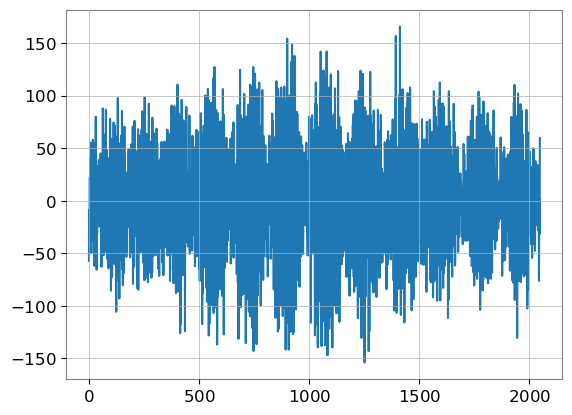

In [202]:
plt.plot(whitened[0][0])

In [206]:
snrs = [5, 8, 20, 30]
hrss = [1e-19]
frequencies = [110]
phases = [0]
qualities = [9]
phi = [0]
dec = [0]
eccentricities = [0]
psi = [0]
waveform_duration = 2
cross, plus = generate_time_domain_sine_gaussian(
    frequencies=frequencies,
    hrss=hrss,
    qualities=qualities,
    phases=phases,
    eccentricities=eccentricities,
    sample_rate=sample_rate,
    duration=waveform_duration,
)
plus = torch.Tensor(plus)
cross = torch.Tensor(cross)

kernel_size = int(kernel_length * sample_rate)

# project raw polarizations onto interferometers
# with sampled sky localizations
tensors, vertices = get_ifo_geometry(*ifos)

# dec is declination
# psi is polarization angle
# phi is relative azimuthal angle between source and earth
dec = torch.Tensor(dec)
psi = torch.Tensor(psi)
phi = torch.Tensor(phi)


waveforms = compute_observed_strain(
    dec,
    psi,
    phi,
    tensors,
    vertices,
    sample_rate,
    plus=plus,
    cross=cross,
)

In [207]:
kernel += waveforms

In [208]:
whitened = preprocessor.whitener(kernel)

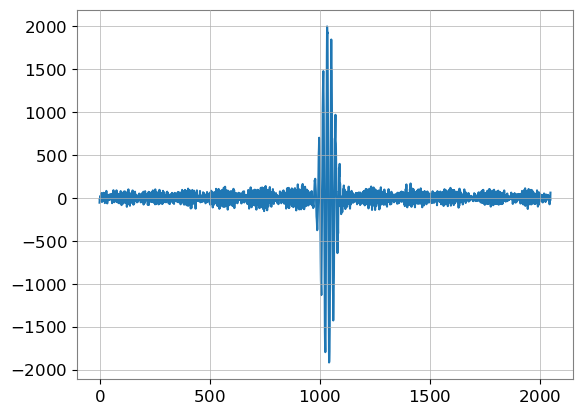

In [210]:
plt.plot(whitened[0][0])

In [211]:
samples = flow.sample(1000, context=whitened.float())

In [190]:
descaled_samples = preprocessor.scaler(
    samples[0].transpose(1, 0), reverse=True
)

(array([0.08246115, 0.        , 0.1649223 , 0.08244818,
        0.        , 0.        , 0.        , 0.1649223 ,
        0.1649223 , 0.24738345, 0.41230576, 1.15427457,
        0.65968921, 1.40183957, 1.73168418, 2.22645109,
        1.56676187, 2.72121799, 2.63875684, 2.22610096,
        3.54582951, 3.2159849 , 4.20551872, 2.22645109,
        4.37044102, 2.96860145, 2.96813461, 3.13352375,
        3.46336835, 2.63875684, 2.39137339, 2.80367914,
        1.81414533, 2.63875684, 1.23672276, 1.81414533,
        1.97906763, 1.48430072, 1.15445612, 1.07199497,
        0.98953382, 1.07199497, 0.74203365, 1.07199497,
        1.15445612, 0.82461151, 0.90707266, 0.65968921,
        0.82461151, 0.41230576, 0.82448184, 0.24738345,
        0.1649223 , 0.24738345, 0.32984461, 0.41230576,
        0.24738345, 0.08244818, 0.08246115, 0.1649223 ,
        0.24738345, 0.24738345, 0.24738345, 0.        ,
        0.08246115, 0.08244818, 0.1649223 , 0.1649223 ,
        0.08246115, 0.08246115, 0.08246115, 0.08

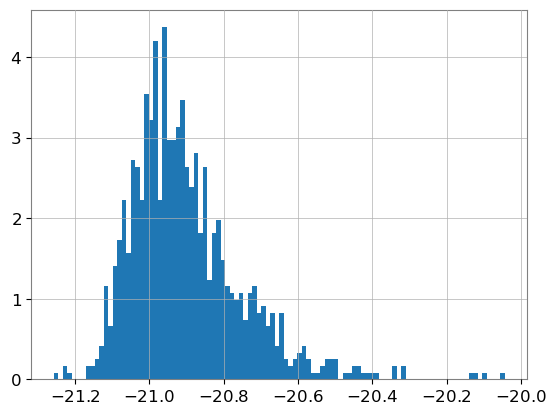

In [172]:
plt.hist(
    torch.log10(torch.exp(descaled_samples[2])).detach().numpy(), bins=100, density=True
)

(array([0.05758164, 0.        , 0.        , 0.        ,
        0.05758164, 0.        , 0.        , 0.05758203,
        0.        , 0.05758203, 0.05758164, 0.05758164,
        0.        , 0.11516327, 0.05758203, 0.34548982,
        0.1727461 , 0.11516327, 0.23032813, 0.46065309,
        0.40307146, 0.74856642, 0.34548982, 1.03647658,
        1.20921437, 1.20922267, 1.95777565, 1.38196877,
        1.84261237, 1.38196877, 2.24568383, 2.53359202,
        2.07295315, 2.13052787, 1.8426187 , 3.10940838,
        2.13052787, 1.72745503, 2.13052787, 1.90020053,
        1.03647302, 1.20921852, 0.80614568, 0.97889118,
        0.51823651, 1.15163669, 0.69097964, 0.86372752,
        0.34549101, 0.46065467, 0.51823651, 0.57581834,
        0.28790917, 0.51823651, 0.34549101, 0.28790917,
        0.23032655, 0.34549101, 0.40307284, 0.34549101,
        0.34549101, 0.23032734, 0.28790917, 0.23032734,
        0.11516347, 0.28790917, 0.23032734, 0.1727455 ,
        0.40307284, 0.46065388, 0.34549101, 0.17

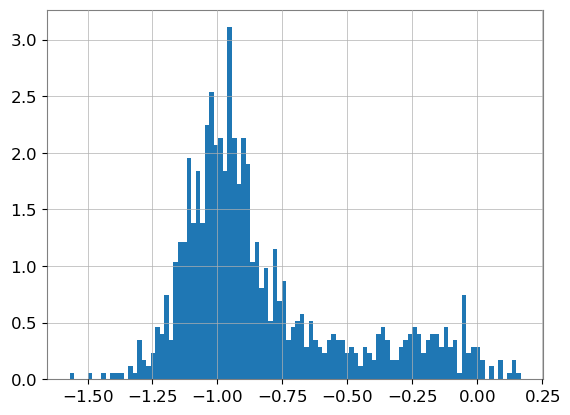

In [214]:
plt.hist(descaled_samples[-3].detach().numpy(), bins=100, density=True)

In [62]:
with h5py.File(train_dir / "raw_batch.h5") as f:
    strain = f["strain"][:]
    

In [70]:
strain.dtype

dtype('float32')

In [72]:
whitened = preprocessor.whitener( torch.tensor(strain).double())

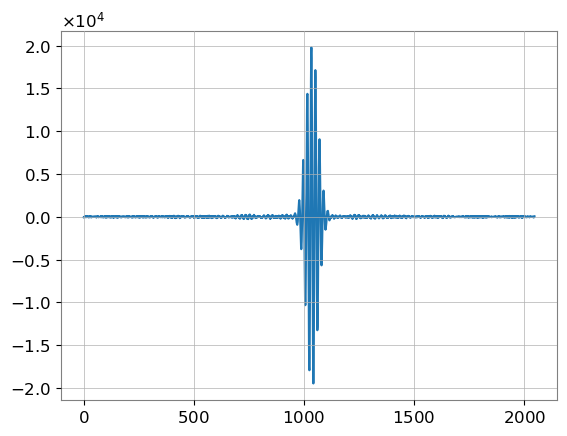

In [134]:
plt.plot(whitened[0][0])